In [66]:
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt

# Preparing for the Exercises

## 1- Starter Code (from previous notebooks)

In [1]:
words = open("../data/names.txt", "r").read().splitlines()
print(words[:8])
print(len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
32033


In [68]:
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(stoi)

print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [69]:
block_size = 3
def build_dataset(words):  

  X, Y = [], []
  
  for w in words:

    context = [0] * block_size
    for ch in w + '.':

      ix = stoi[ch]

      X.append(context)
      Y.append(ix)

      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [70]:
n_embd = 10 
n_hidden = 64

g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),generator=g) * (5/3) / ((n_embd * block_size) ** 0.5)
b1 = torch.randn(n_hidden,generator=g) * 0.01 # it's actually useless
W2 = torch.randn((n_hidden, vocab_size),generator=g) * 0.01 # Initialize to small values
b2 = torch.randn(vocab_size,generator=g) * 0.1

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

# mean and std buffers, (not trainable)
bnmean_running = torch.zeros((1, n_hidden)) * 0.1 + 1
bnstd_running = torch.ones((1, n_hidden)) * 0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad = True

4137


In [71]:
batch_size = 32
n = batch_size

ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]

## 2- Utility Function to compare the Gradients

In [72]:
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

## 3- Forward pass
the forward back in this time is broken up into manageable chunks, so that we can compute the gradients for each layer separately (including cross entropy)

This is the same forward pass as in the previous notebook.

In [73]:
# ----- Embeddings -----
emb = C[Xb]
embcat = emb.view(emb.shape[0], -1)

# ----- Linear Layer 1 -----
# hidden layer pre-activation
hprebn = embcat @ W1 + b1
# ---- BatchNorm layer ----
# mean of hidden layer pre-activation
bnmeani = 1 / n * hprebn.sum(0, keepdim = True)
# difference between pre-activation and mean
bndiff = hprebn - bnmeani
# square of difference
bndiff2 = bndiff ** 2
# variance of hidden layer pre-activation (Bessel's correction (n-1))
bnvar = 1 / (n - 1) * (bndiff2).sum(0, keepdim = True)
# get the std of hidden layer pre-activation, and invert it (remember: we need to divide by it)
bnvar_inv = 1 / (bnvar + 1e-5) ** 0.5
# batch norm layer output
bnraw = bndiff * bnvar_inv
# batch norm layer output with gain and bias (scale and shift)
hpreact = bngain * bnraw + bnbias
# activation function
h = torch.tanh(hpreact)

# ----- Linear Layer 2 -----
# logits
logits = h @ W2 + b2

# ----- Cross Entropy Loss -----
# max logits
logit_maxes = logits.max(1, keepdim = True).values
# normalized logits (substract max logits for numerical stability)
norm_logits = logits - logit_maxes
# counts
counts = norm_logits.exp()
# counts sum
counts_sum = counts.sum(1, keepdim = True)
# inverse of counts sum (if it's 1 / counts_sum, we can't backpropagate through it)
counts_sum_inv = counts_sum ** -1
# probabilities (all counts sum to 1), notice that counts_sum_inv is broadcasted from (batch_size, 1) to (batch_size, vocab_size)
probs = counts * counts_sum_inv
# log probabilities of the correct next character (shape: (batch_size, vocab_size))
logprobs = probs.log()
# loss
loss = -logprobs[range(n), Yb].mean()

In [74]:
for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, norm_logits, logit_maxes, logits, h, hpreact, bnraw, bnvar_inv, bnvar, bndiff2, bndiff, bnmeani, hprebn, embcat, emb]:
    t.retain_grad()

loss.backward()
loss

tensor(3.2968, grad_fn=<NegBackward0>)

# Exercise 1: Backpropagation through the whole thing manually

In [75]:
# z = -(a + b + c) / 3 ➡️ dz/da = -1/3, dz/dx = 0
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0 / n

# for correct prediction ✅: pass dlogprobs | if it's not correct ❌: multiply it by large number
# y = log(x) ➡️ dy/dx = 1/x
dprobs = dlogprobs * (probs ** (-1))

# note that counts.shape = (batch_size, vocab_size) | counts_sum.shape = (batch_size, 1) ➡️ we need to sum along the vocab_size axis (dim=1)
# z = x * y ➡️ dz/dx = y
dcounts_sum_inv = (dprobs * counts).sum(1, keepdim = True)

# z = 1 / x ➡️ dz/dx = -1 / x^2
dcounts_sum = dcounts_sum_inv * -1 * (counts_sum ** -2)

# note that counts is used twice ➡️ we need to sum gradients from both branches
dcounts = (dcounts_sum * 1).expand_as(counts) + (dprobs * counts_sum_inv).expand_as(counts)

# y = exp(x) ➡️ dy/dx = exp(x)
dnorm_logits = dcounts  * norm_logits.exp()

# the gradient on logit maxes should be zero , since it does affect probabilities hence the loss (check it yourself!)
# z = x - y ➡️ dz/dx = 1 (remember broadcasting)
dlogit_maxes = (dnorm_logits * -1).sum(1, keepdim = True)

# note that logits is used twice ➡️ we need to sum gradients from both branches
# for logit_maxes branch, we need to get argmaxes of logits, and then sum along the vocab_size  axis (dim=1)
dlogits = dnorm_logits + F.one_hot(logits.max(1).indices, num_classes = logits.shape[1]) * dlogit_maxes

# z = x * y ➡️ dz/dx = y (transpose because of matrix multiplication)
dh = dlogits @ W2.T

# z = x * y ➡️ dz/dx = x (transpose because of matrix multiplication)
dW2 = h.T @ dlogits

# z = x * y + a ➡️ dz/da = 1 (sum along the batch_size axis)
db2 = dlogits.sum(0, keepdim = False)

# z = tanh(x) ➡️ dz/dx = 1 - tanh(x)^2 = 1 - z^2
dhpreact = dh * (1.0 - h ** 2)

# z = x * y + a ➡️ dz/dx = y (transpose because of matrix multiplication)
dbngain = (dhpreact * bnraw).sum(0, keepdim = True)

# z = x * y + a ➡️ dz/da = 1 (sum along the batch_size axis)
dbnbias = dhpreact.sum(0, keepdim=True)

# z = x * y + a ➡️ dz/dy = x
dbnraw = (bngain * dhpreact)

dbnvar_inv = (dbnraw * bndiff).sum(0, keepdim = True)

# z = 1 / (x + 1e-5) ** 0.5 ➡️ dz/dx = -0.5 * (x + 1e-5) ** -1.5
dbnvar = dbnvar_inv * -0.5 * (bnvar + 1e-5) ** -1.5

# y = 1 / (n - 1) * x ➡️ dy/dx = 1 / (n - 1)
dbndiff2 = (dbnvar * (1 / (n - 1))).expand_as(bndiff2)

# z = x ** 2 ➡️ dz/dx = 2 * x
dbndiff = (dbndiff2 * 2 * bndiff) + (dbnraw * bnvar_inv)

# z = y - x ➡️ dz/dx = -1
dbnmeani = (dbndiff * -1).sum(0, keepdim = True)

# note that hprebn is used twice ➡️ we need to sum gradients from both branches
dhprebn = dbndiff + (dbnmeani * (1 / n)).expand_as(hprebn)

# z = x * y + a ➡️ dz/dx = y (transpose because of matrix multiplication)
dembcat = dhprebn @ W1.T

# z = x * y + a ➡️ dz/dx = y (transpose because of matrix multiplication)
dW1 = embcat.T @ dhprebn

# z = x * y + a ➡️ dz/da = 1 (sum along the batch_size axis)
db1 = dhprebn.sum(0, keepdim = False)

# just reshape the gradient to the shape of the embedding
demb = dembcat.view_as(emb)

# we need to undo the embedding lookup (the indexing)
dC = torch.zeros_like(C)
# iterate over Xb rows
for k in range(Xb.shape[0]):
    # iterate over Xb columns
    for j in range(Xb.shape[1]):
        # get the index of the current character
        ix = Xb[k, j]
        # add the gradient to the corresponding row of the gradient matrix
        dC[ix] += demb[k, j]

In [76]:
# Change this with the shapes of the tensors you're currently working with
print(f"C shape{C.shape}")
print(f"emb shape{emb.shape}")
print(f"Xb shape{Xb.shape}")

C shapetorch.Size([27, 10])
emb shapetorch.Size([32, 3, 10])
Xb shapetorch.Size([32, 3])


## Comparison

In [77]:
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: False | approximate: True  | maxdiff: 5.820766091346741e-11
bngain          | exact: False | approximate: True  | maxdiff: 1.7462298274040222e-10
bnbias          | exact: False | approximate: True  | maxdiff: 2.3283064365386963e-10
bnraw 

# Exercise 2: Backprop through cross_entropy in one expression

In [46]:
loss_fast = F.cross_entropy(logits, Yb)
print(f"loss_fast: {loss_fast} | dif: {loss_fast - loss}")

loss_fast: 3.296769618988037 | dif: 2.384185791015625e-07


In [78]:
# (check mathematical explaination in video)
dlogits = F.softmax(logits, dim = 1)
dlogits[range(n), Yb] -= 1
dlogits /= n

cmp('logits', dlogits, logits)

logits          | exact: False | approximate: True  | maxdiff: 6.984919309616089e-09


## Visualize the gradients (dlogits)

tensor([0.0434, 0.0369, 0.0356, 0.0364, 0.0329, 0.0465, 0.0415, 0.0422, 0.0360,
        0.0344, 0.0364, 0.0332, 0.0411, 0.0353, 0.0327, 0.0352, 0.0318, 0.0318,
        0.0330, 0.0446, 0.0408, 0.0316, 0.0383, 0.0391, 0.0435, 0.0349, 0.0311],
       grad_fn=<SelectBackward0>)
tensor([ 0.0434,  0.0369,  0.0356,  0.0364,  0.0329,  0.0465,  0.0415,  0.0422,
        -0.9640,  0.0344,  0.0364,  0.0332,  0.0411,  0.0353,  0.0327,  0.0352,
         0.0318,  0.0318,  0.0330,  0.0446,  0.0408,  0.0316,  0.0383,  0.0391,
         0.0435,  0.0349,  0.0311], grad_fn=<MulBackward0>)


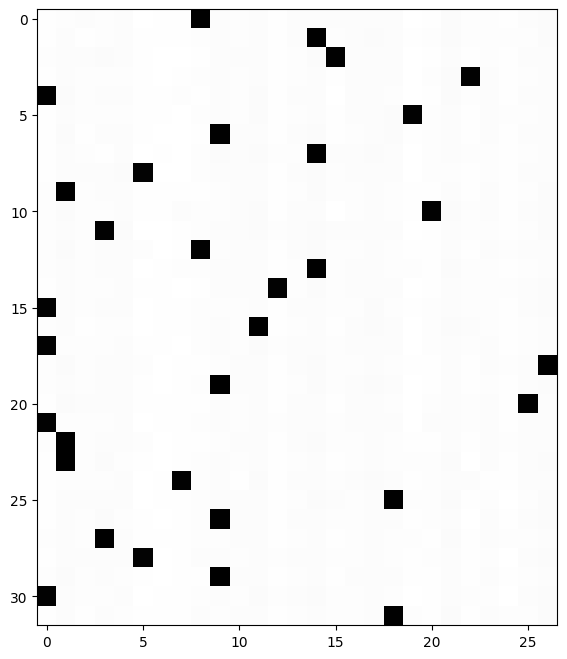

In [85]:
plt.figure(figsize = (8, 8))
plt.imshow(dlogits.data, cmap = 'gray', interpolation = 'nearest');

# notice that they are equal, but correct posision is almost -1
print(F.softmax(logits, 1)[0])
print(dlogits[0] * n)

# Exercise 3: Batch Norm Layer Backward Pass in one Expression

In [87]:
# calculate hprebn given hpreact (check mathematical explaination in video)
dhprebn = bngain * bnvar_inv / n * (n * dhpreact - dhpreact.sum(0) - n / (n - 1) * bnraw * (dhpreact * bnraw).sum(0))

cmp('hprebn', dhprebn, hprebn)

hprebn          | exact: False | approximate: True  | maxdiff: 5.820766091346741e-11


# Exercise 4: Putting it all together

In [93]:
# init
n_embd = 10 
n_hidden = 64

g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden),generator=g) * (5/3) / ((n_embd * block_size) ** 0.5)
b1 = torch.randn(n_hidden,generator=g) * 0.01 # it's actually useless
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),generator=g) * 0.01 # Initialize to small values
b2 = torch.randn(vocab_size,generator=g) * 0.1
# BatchNorm Parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

# mean and std buffers, (not trainable)
bnmean_running = torch.zeros((1, n_hidden)) * 0.1 + 1
bnstd_running = torch.ones((1, n_hidden)) * 0.1

params = [C, W1, b1, W2, b2, bngain, bnbias]

for p in parameters:
    p.requires_grad = True

max_steps = 200000
batch_size = 32
n = batch_size 
lossi = []

for i in range(max_steps):

    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # ----- Embeddings -----
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)

    # ----- Linear Layer 1 -----
    # hidden layer pre-activation
    hprebn = embcat @ W1 + b1
    # ---- BatchNorm layer ----
    # mean of hidden layer pre-activation
    bnmeani = 1 / n * hprebn.sum(0, keepdim = True)
    # difference between pre-activation and mean
    bndiff = hprebn - bnmeani
    # square of difference
    bndiff2 = bndiff ** 2
    # variance of hidden layer pre-activation (Bessel's correction (n-1))
    bnvar = 1 / (n - 1) * (bndiff2).sum(0, keepdim = True)
    # get the std of hidden layer pre-activation, and invert it (remember: we need to divide by it)
    bnvar_inv = 1 / (bnvar + 1e-5) ** 0.5
    # batch norm layer output
    bnraw = bndiff * bnvar_inv
    # batch norm layer output with gain and bias (scale and shift)
    hpreact = bngain * bnraw + bnbias
    # activation function
    h = torch.tanh(hpreact)

    # ----- Linear Layer 2 -----
    # logits
    logits = h @ W2 + b2

    # ----- Cross Entropy Loss -----
    loss = F.cross_entropy(logits, Yb)

    # ----- Backpropagation -----
    for p in parameters:
        p.grad = None
    
    # one expression
    dlogits = F.softmax(logits, dim = 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n

    # z = x * y ➡️ dz/dx = y (transpose because of matrix multiplication)
    dh = dlogits @ W2.T

    # z = x * y ➡️ dz/dx = x (transpose because of matrix multiplication)
    dW2 = h.T @ dlogits

    # z = x * y + a ➡️ dz/da = 1 (sum along the batch_size axis)
    db2 = dlogits.sum(0, keepdim = False)

    # z = tanh(x) ➡️ dz/dx = 1 - tanh(x)^2 = 1 - z^2
    dhpreact = dh * (1.0 - h ** 2)

    # z = x * y + a ➡️ dz/dx = y (transpose because of matrix multiplication)
    dbngain = (dhpreact * bnraw).sum(0, keepdim = True)

    # z = x * y + a ➡️ dz/da = 1 (sum along the batch_size axis)
    dbnbias = dhpreact.sum(0, keepdim=True)

    # one expression
    dhprebn = bngain * bnvar_inv / n * (n * dhpreact - dhpreact.sum(0) - n / (n - 1) * bnraw * (dhpreact * bnraw).sum(0))

    # z = x * y + a ➡️ dz/dx = y (transpose because of matrix multiplication)
    dembcat = dhprebn @ W1.T

    # z = x * y + a ➡️ dz/dx = y (transpose because of matrix multiplication)
    dW1 = embcat.T @ dhprebn

    # z = x * y + a ➡️ dz/da = 1 (sum along the batch_size axis)
    db1 = dhprebn.sum(0, keepdim = False)

    # just reshape the gradient to the shape of the embedding
    demb = dembcat.view_as(emb)

    # we need to undo the embedding lookup (the indexing)
    dC = torch.zeros_like(C)
    # iterate over Xb rows
    for k in range(Xb.shape[0]):
        # iterate over Xb columns
        for j in range(Xb.shape[1]):
            # get the index of the current character
            ix = Xb[k, j]
            # add the gradient to the corresponding row of the gradient matrix
            dC[ix] += demb[k, j]
            
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]

    # update the parameters
    lr = 0.1 if i < 100000 else 0.01
    for p, grad in zip(params, grads):
        p.data -= lr * grad
    
    if i % 10000 == 0:
        print(f"Step {i}, Loss {loss.item()}")
        lossi.append(loss.item())
  

Step 0, Loss 3.296769618988037
Step 10000, Loss 2.4469268321990967
Step 20000, Loss 2.0859169960021973
Step 30000, Loss 2.388929605484009
Step 40000, Loss 2.2814080715179443
Step 50000, Loss 2.1699628829956055
Step 60000, Loss 2.2227632999420166
Step 70000, Loss 2.5007517337799072
Step 80000, Loss 2.1813900470733643
Step 90000, Loss 2.4679534435272217
Step 100000, Loss 2.095520257949829
Step 110000, Loss 1.7801880836486816
Step 120000, Loss 2.076627731323242
Step 130000, Loss 2.4670305252075195
Step 140000, Loss 1.8943418264389038
Step 150000, Loss 2.13836932182312
Step 160000, Loss 2.0354418754577637
Step 170000, Loss 2.303077220916748
Step 180000, Loss 1.9737322330474854
Step 190000, Loss 1.993587613105774


In [100]:
# batchnorm calibration
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bnmean = hpreact.mean(0, keepdim = True)
    bnvar = hpreact.var(0, keepdim = True, unbiased = True)

In [106]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        "train": (Xtr, Ytr),
        "dev": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]

    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view((emb.shape[0], -1)) # (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1 # (N, n_hidden)
    hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)

    print(f"{split} loss: {loss.item()}")

split_loss("train")
split_loss("dev")

train loss: 2.1448161602020264
dev loss: 2.1594536304473877


In [143]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # ------------
      # forward pass:
      # Embedding
      emb = C[torch.tensor([context])] # (1,block_size,d)      
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # ------------
      # Sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mora.
kmyah.
see.
mad.
rylla.
emmastendraeg.
adelynneli.
jemi.
jen.
eden.
sananar.
kayzion.
kalin.
shubergias.
jest.
jair.
jennex.
teron.
ubelled.
ryyah.
